In [586]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import calendar


---

# Load Datasets


In [587]:
all_fire_weather = pd.read_csv(
    "../../data/processed/wildfire_weather.csv",
    parse_dates=["firediscoverydatetime", "controldatetime", "containmentdatetime"],
)
big_fire_weather = pd.read_csv(
    "../../data/processed/bigger_wildfire_weather_extra_180d.csv",
    parse_dates=["firediscoverydatetime", "controldatetime", "containmentdatetime"],
)


In [588]:
all_fire_weather.shape, big_fire_weather.shape


((21518, 37), (2053, 45))

----
# Drop Columns Not Needed

In [589]:
cols_not_needed = [
    "id",
    "x",
    "y",
    "initiallatitude",
    "initiallongitude",
    "incidenttypecategory",
    "irwinid",
    "incidenttypekind",
    "poodispatchcenterid",
    "uniquefireidentifier",
]
all_fire_weather.drop(columns=cols_not_needed, inplace=True)

big_fire_weather.drop(columns=cols_not_needed, inplace=True)


---

# Check for null


In [590]:
def check_null(df):
    """This function prints number of columns missing data

    Args:
        df (DataFrame): dataset in pandas dataframe format
    """
    print(f"Total missing data: {len(df.isna().sum()[df.isna().sum() > 0])}")


In [591]:
check_null(all_fire_weather)
check_null(big_fire_weather)


Total missing data: 0
Total missing data: 0


---

# Confirm Date Columns


In [592]:
all_fire_weather.select_dtypes("datetime64[ns, UTC]").head(1)


,containmentdatetime,controldatetime,firediscoverydatetime
0,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,2020-07-22 21:51:00+00:00


In [593]:
big_fire_weather.select_dtypes("datetime64[ns, UTC]").head(1)


,containmentdatetime,controldatetime,firediscoverydatetime
0,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,2020-07-19 23:00:00+00:00


---

# Extract Year, Month, Day from date columns


In [594]:
def extract_dates(df):
    """Generates separate columns for each datetime columns from original dataframe

    Args:
        df (DataFrame): dataset in pandas dataframe format
    """
    date_df = df.select_dtypes("datetime64[ns, UTC]")

    for column in date_df.columns:
        df[f"{column}_year"] = date_df[column].dt.year
        df[f"{column}_month"] = date_df[column].dt.month
        df[f"{column}_day"] = date_df[column].dt.dayofweek


In [595]:
extract_dates(all_fire_weather)
all_fire_weather.head(1)


,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,localincidentidentifier,poocounty,poofips,poostate,...,rain_sum,containmentdatetime_year,containmentdatetime_month,containmentdatetime_day,controldatetime_year,controldatetime_month,controldatetime_day,firediscoverydatetime_year,firediscoverydatetime_month,firediscoverydatetime_day
0,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,1450,Pinal,4021,US-AZ,...,2.6,2020,7,3,2020,7,3,2020,7,2


In [596]:
extract_dates(big_fire_weather)
big_fire_weather.head(1)


,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,localincidentidentifier,poocounty,poofips,poostate,...,sum_snow,containmentdatetime_year,containmentdatetime_month,containmentdatetime_day,controldatetime_year,controldatetime_month,controldatetime_day,firediscoverydatetime_year,firediscoverydatetime_month,firediscoverydatetime_day
0,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,10145,Elko,32007,US-NV,...,1.32,2020,8,0,2020,9,2,2020,7,6


---


In [597]:
peak_fire_month = {
    'min': 5,
    'max': 8
}

def plot_by_arg(
    df,
    filter_arg,
    figsize,
    title,
    title_fontsize,
    xlabel,
    ylabel,
    xlabel_fontsize,
    ylabel_fontsize,
    bar_color,
    file_path,
    hue_labels=[],
    rotation=45,
    top_bar_count=False,
    xticks_name=[],
    hue=None,
):
    columns = list(
        filter(None, df.columns.map(lambda x: x if re.search(filter_arg, x) else None))
    )

    for col in columns:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title, size=title_fontsize)

        # Plot
        ax = sns.countplot(df, x=col, palette=bar_color, ax=ax, hue=hue)

        if top_bar_count:
            for p in ax.patches:
                ax.annotate(
                    "{:.0f}".format(p.get_height()),
                    (p.get_x() + 0.36, p.get_height() + 1.01),
                )

        # Set Labels
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)

        # Xticks
        if xticks_name:
            ax.set_xticks(
                np.arange(0, len(xticks_name)), xticks_name, rotation=rotation
            )

        if hue:
            ax.legend(loc="upper right", labels=hue_labels)

        plt.savefig(file_path)
        
        plt.show()



# Fire By Year

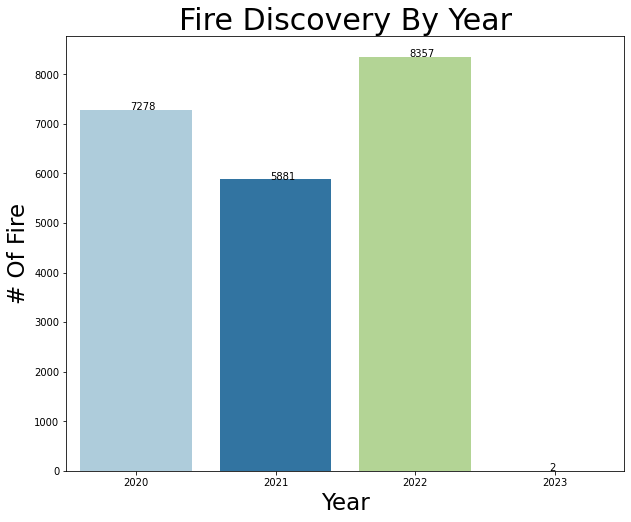

In [598]:
plot_by_arg(
    all_fire_weather,
    "firediscoverydatetime_year",
    figsize=(10, 8),
    title="Fire Discovery By Year",
    xlabel="Year",
    ylabel="# Of Fire",
    top_bar_count=True,
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    file_path='../../public/visuals/fire_by_year'
)


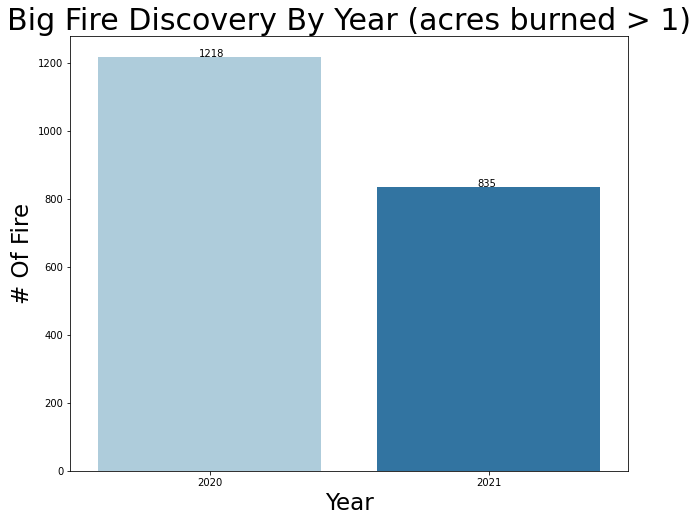

In [599]:
plot_by_arg(
    big_fire_weather,
    "firediscoverydatetime_year",
    figsize=(10, 8),
    title="Big Fire Discovery By Year (acres burned > 1)",
    xlabel="Year",
    ylabel="# Of Fire",
    top_bar_count=True,
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    file_path='../../public/visuals/big_fire_by_year'
)


> Dataset we have mainly includes fire datasets from 3 years and 2022 when amount of fires has peaked between these years. Next I want to see what it looks like per month

# Fire By Month

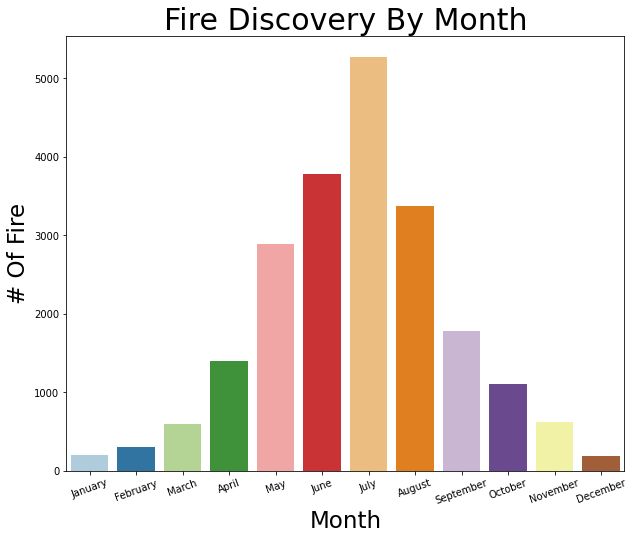

In [600]:
plot_by_arg(
    all_fire_weather,
    "firediscoverydatetime_month",
    figsize=(10, 8),
    title="Fire Discovery By Month",
    xlabel="Month",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[1:],
    rotation=20,
    file_path='../../public/visuals/fire_by_month'
)


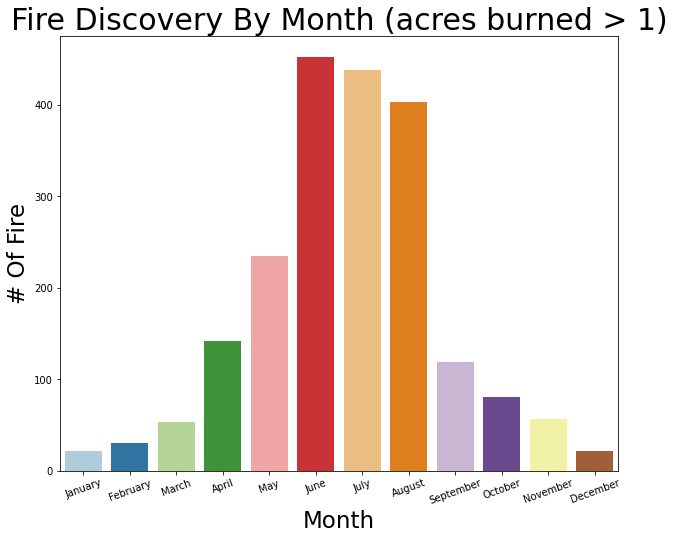

In [601]:
plot_by_arg(
    big_fire_weather,
    "firediscoverydatetime_month",
    figsize=(10, 8),
    title="Fire Discovery By Month (acres burned > 1)",
    xlabel="Month",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.month_name)[1:],
    rotation=20,
    file_path='../../public/visuals/big_fire_by_mongth'
)


> Charts show highest peak is between april and september. Next is interesting to look at which day of the week has most fires accrued for peak months

# Peak Fire Per Weekday By Month

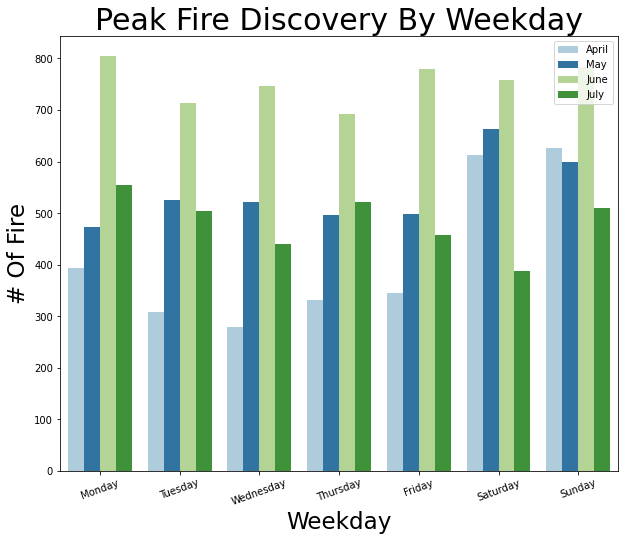

In [602]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Peak Fire Discovery By Weekday",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firediscoverydatetime_month",
    hue_labels=list(calendar.month_name)[4:10],
    file_path='../../public/visuals/peak_fire_by_weekday'
)


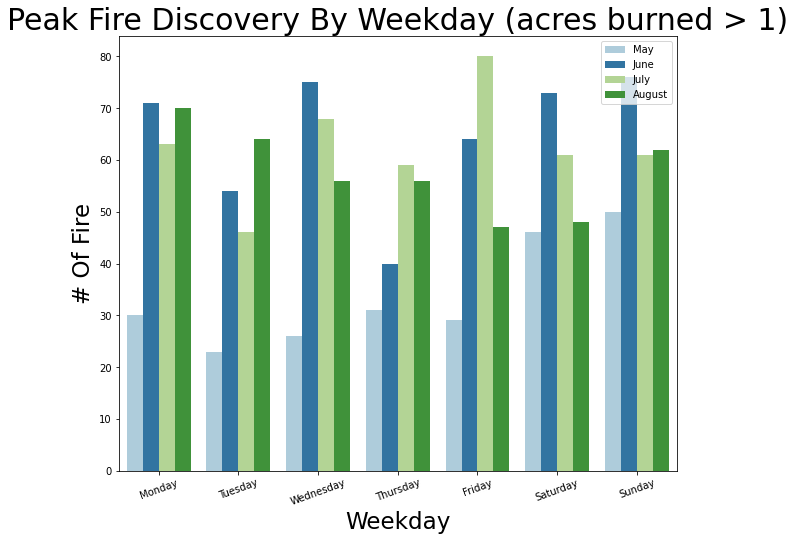

In [603]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Peak Fire Discovery By Weekday (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firediscoverydatetime_month",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:10],
    file_path='../../public/visuals/peak_big_fire_by_weekday'
)


> Chart shows that fires started regardless of day of the week. Next is interesting to look at what caused the fire during peak fire months

# Fire Cause During Peak Fire

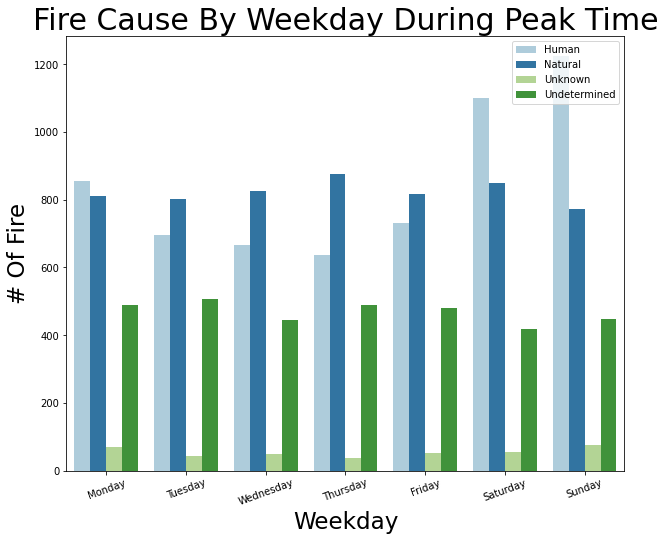

In [604]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Fire Cause By Weekday During Peak Time",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(all_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/peak_fire_cause_by_weekday'
)


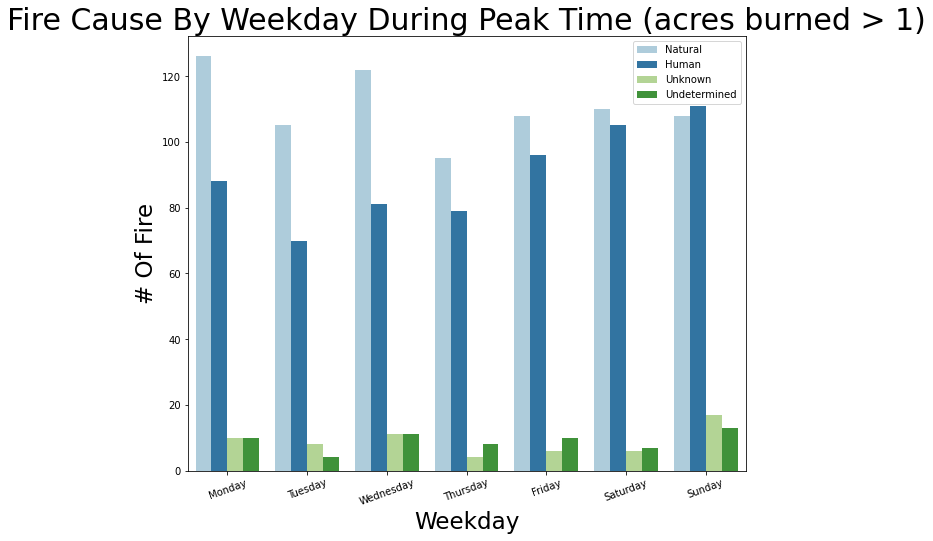

In [605]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Fire Cause By Weekday During Peak Time (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(big_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/peak_big_fire_by_weekday'
)


> Natural cause of fire dominates during weekday and human cause peaks during weekend which makes sense since more people go camping and increase the risk

----

# Fire Cause During Slow Time

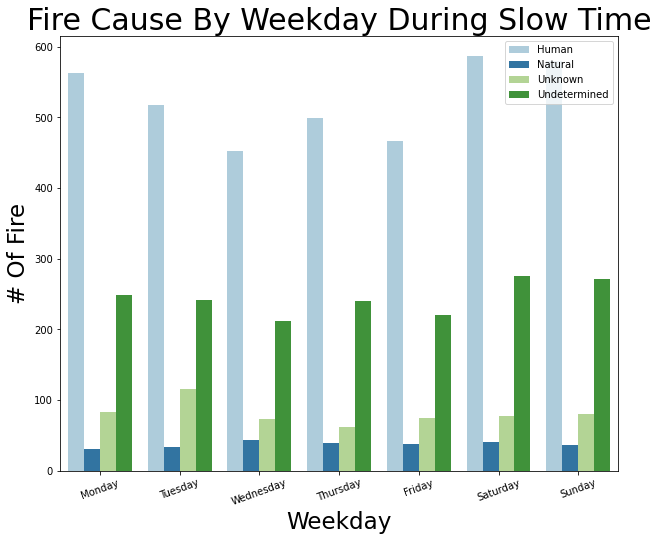

In [606]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] > peak_fire_month['max'])
        | (all_fire_weather["firediscoverydatetime_month"] < peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Fire Cause By Weekday During Slow Time",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(all_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/slow_fire_by_weekday'
)


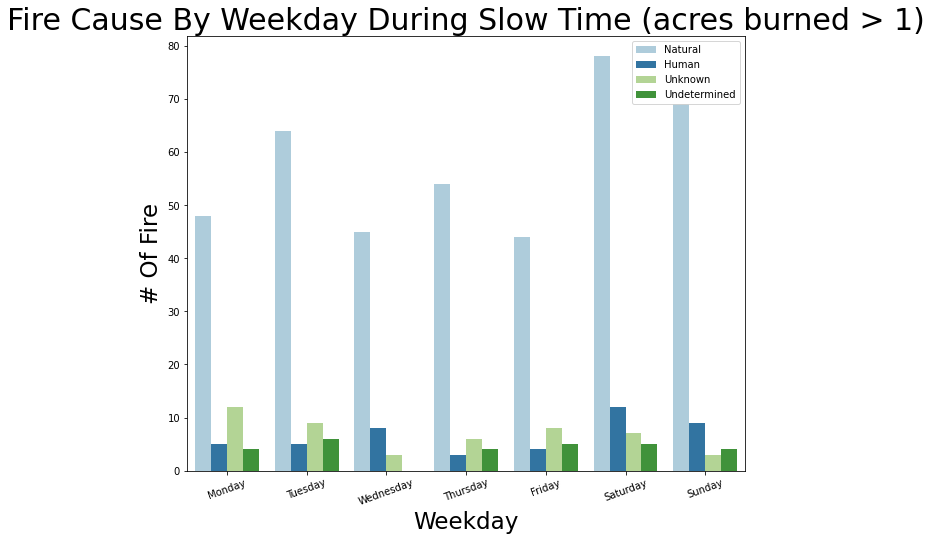

In [607]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] > peak_fire_month['max'])
        | (big_fire_weather["firediscoverydatetime_month"] < peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Fire Cause By Weekday During Slow Time (acres burned > 1)",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="firecause",
    hue_labels=list(big_fire_weather['firecause'].unique()),
    file_path='../../public/visuals/slow_big_fire_by_weekday'
)


> During slow fire season natural causes dominates across the board. Next it is interesting to find what is common conditions for peak fire.

----
# Peak Fire Common Conditions

In [608]:
temp_cols = [col for col in all_fire_weather.columns if re.search("^(temp_)", col)]
wind_cols = [col for col in all_fire_weather.columns if re.search("^(wind_)", col)]
misc_cols = [
    "firediscoverydatetime_day",
    "firediscoverydatetime_month",
    "firediscoverydatetime_year",
    "controldatetime_day",
    "controldatetime_month",
    "controldatetime_year",
    "containmentdatetime_day",
    "containmentdatetime_month",
    "containmentdatetime_year",
]

cols_to_remove = np.concatenate((temp_cols[1:], wind_cols[1:], misc_cols), axis=0)

C:\Users\btoli\AppData\Local\Temp\ipykernel_20196\108745531.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_fire_weather[


<AxesSubplot: >

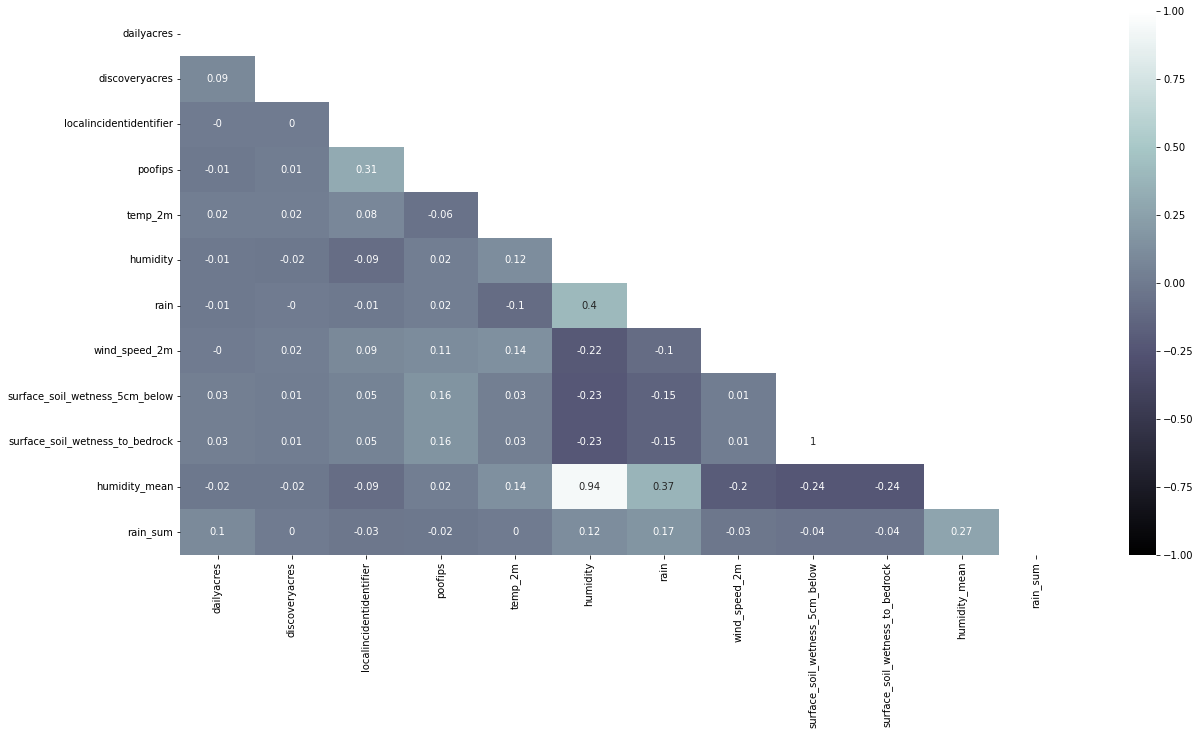

In [609]:
corr = (
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ]
    .drop(
        columns=cols_to_remove
    )
    .corr()
)

corr = round(corr, 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="bone",
    mask=mask,
)


C:\Users\btoli\AppData\Local\Temp\ipykernel_20196\3906673253.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  big_fire_weather[


<AxesSubplot: >

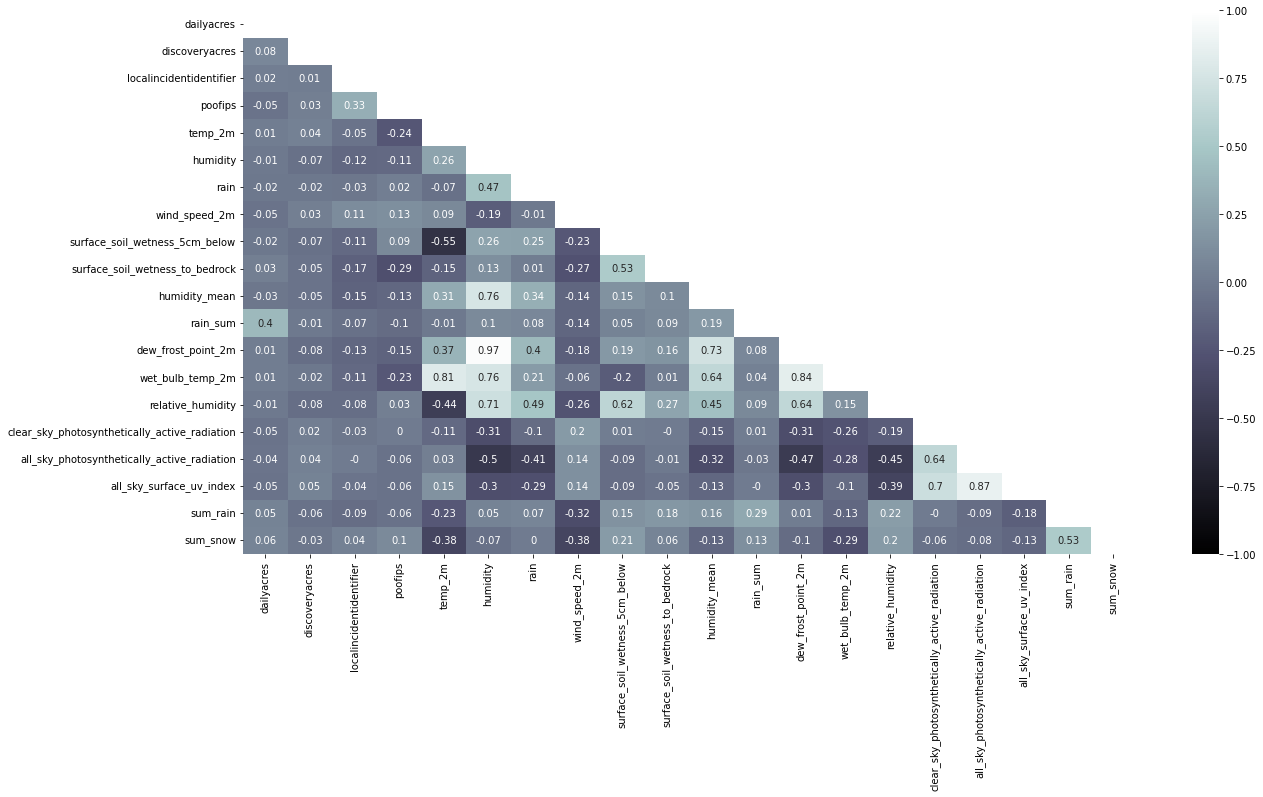

In [610]:
corr = (
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ]
    .drop(
        columns=cols_to_remove
    )
    .corr()
)

corr = round(corr, 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="bone",
    mask=mask,
)


- Temp at 2m: 
  - Wind Speed Gust at 2m Positive 0.18
- Humidity:
  - Wind Speed at 10m mean -0.27
  - Surface Soil Wetness to Bedrock -0.25

----


In [611]:
# 
temp_df = all_fire_weather.drop(columns=cols_to_remove)
temp_df.select_dtypes('O')


,firecause,poocounty,poostate
0,Human,Pinal,US-AZ
1,Natural,Elko,US-NV
2,Natural,Rio Blanco,US-CO
3,Human,Uintah,US-UT
4,Human,Cochise,US-AZ
...,...,...,...
21513,Human,Coconino,US-AZ
21514,Undetermined,Grant,US-NM
21515,Undetermined,Fresno,US-CA
21516,Undetermined,Curry,US-OR


----
# Peak Fire Discovery By State On Weekday

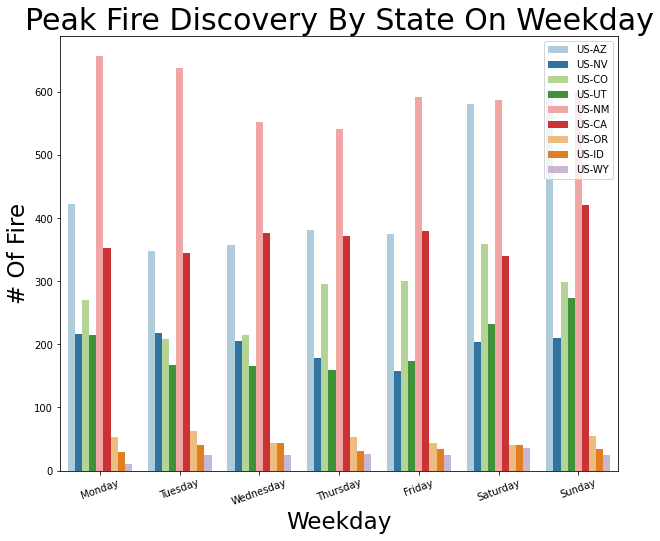

In [612]:
plot_by_arg(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Peak Fire Discovery By State On Weekday",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="poostate",
    hue_labels=all_fire_weather['poostate'].unique(),
    file_path='../../public/visuals/fire_by_state_per_weekday'
)


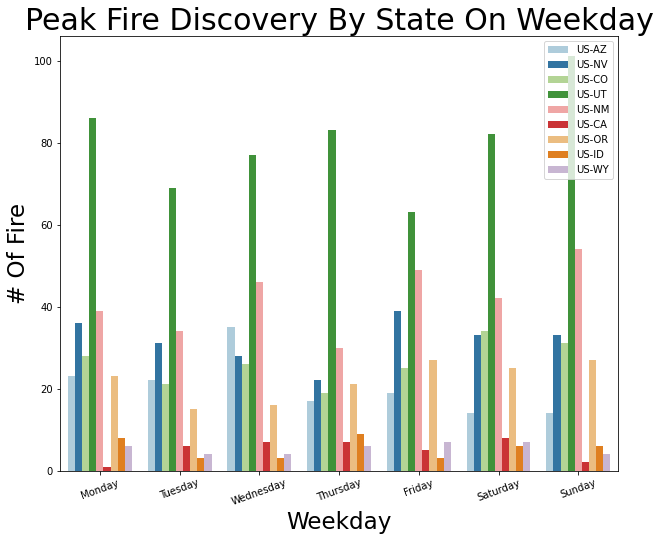

In [613]:
plot_by_arg(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= 4)
    ],
    "firediscoverydatetime_day",
    figsize=(10, 8),
    title="Peak Fire Discovery By State On Weekday",
    xlabel="Weekday",
    ylabel="# Of Fire",
    title_fontsize=30,
    xlabel_fontsize=23,
    ylabel_fontsize=23,
    bar_color=sns.color_palette("Paired"),
    xticks_name=list(calendar.day_name),
    rotation=20,
    hue="poostate",
    hue_labels=all_fire_weather['poostate'].unique(),
    file_path='../../public/visuals/fire_by_state_per_weekday'
)


----
# Peak Temperature By State

In [614]:
def plot_per_state(df, target, file_path, hue_labels, title, xlabel, ylabel, hue):
  fig, ax = plt.subplots(1, 1, figsize=(16, 10))

  tdf = df.groupby(['poostate', 'firediscoverydatetime_month']).max()[[target]].reset_index()

  sns.barplot(tdf, x=target, y='poostate', hue=hue, orient = 'h', ax=ax)
  
  ax.set_title(title, fontsize=30, fontweight='bold')
  ax.set_ylabel(ylabel, fontsize=20)
  ax.set_xlabel(xlabel, fontsize=20)
  if hue_labels:
      ax.legend(loc="lower right", labels=hue_labels)

  plt.savefig(file_path)

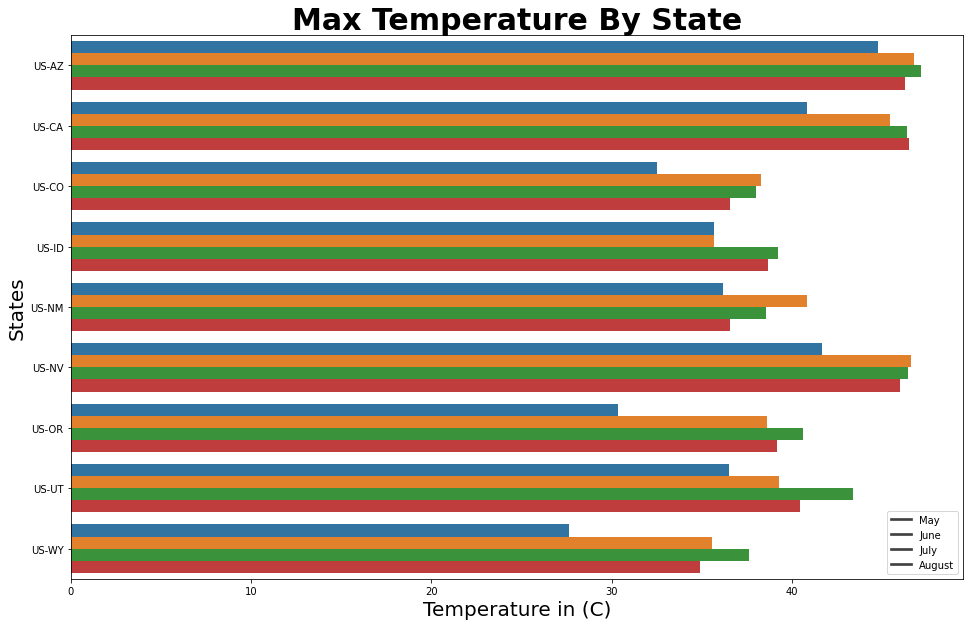

In [615]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="temp_2m_max",
    file_path="../../public/visuals/fire_max_temp_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Max Temperature By State',
    xlabel='Temperature in (C)',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


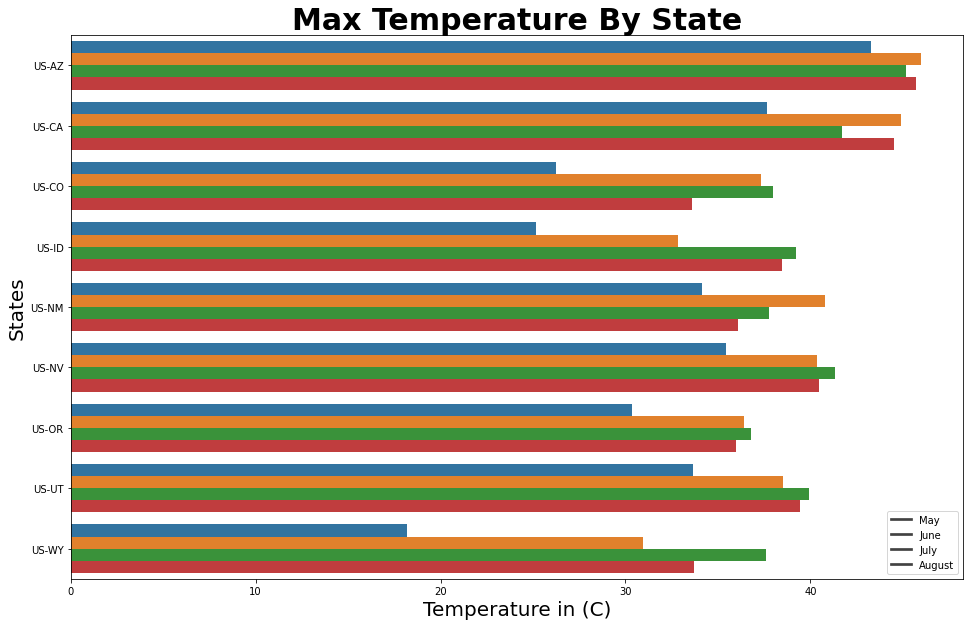

In [616]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="temp_2m_max",
    file_path="../../public/visuals/big_fire_max_temp_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Max Temperature By State',
    xlabel='Temperature in (C)',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Humidity By State At Peak Fire

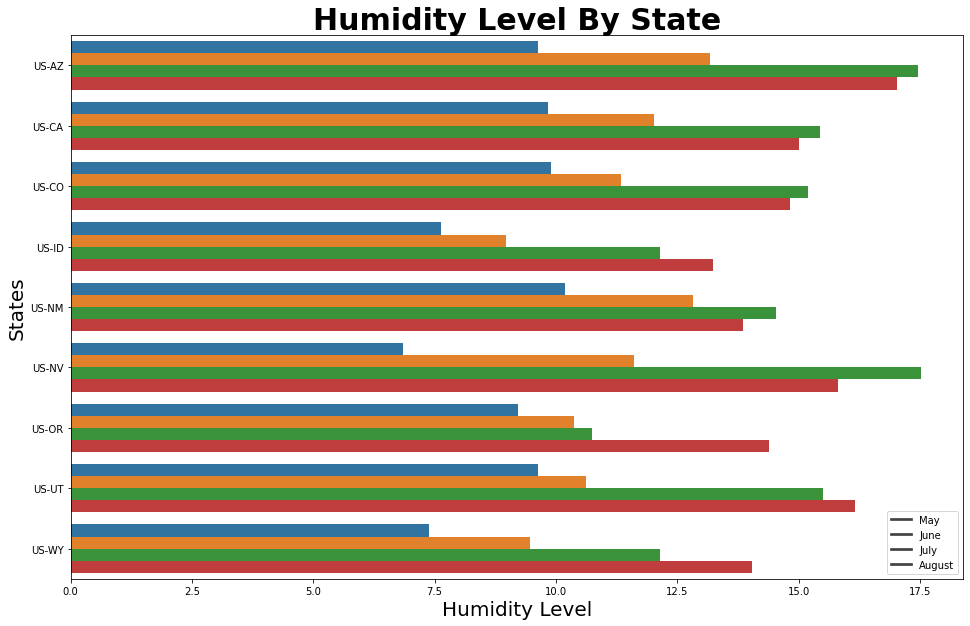

In [617]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="humidity",
    file_path="../../public/visuals/fire_humidity_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Humidity Level By State',
    xlabel='Humidity Level',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


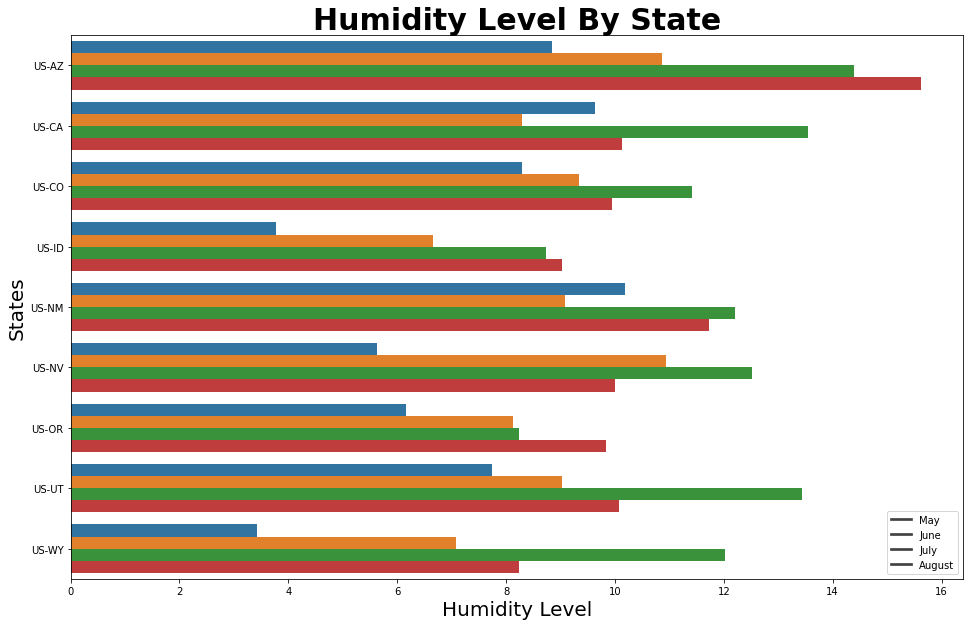

In [618]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="humidity",
    file_path="../../public/visuals/big_fire_humidity_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Humidity Level By State',
    xlabel='Humidity Level',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Wind Speed By State

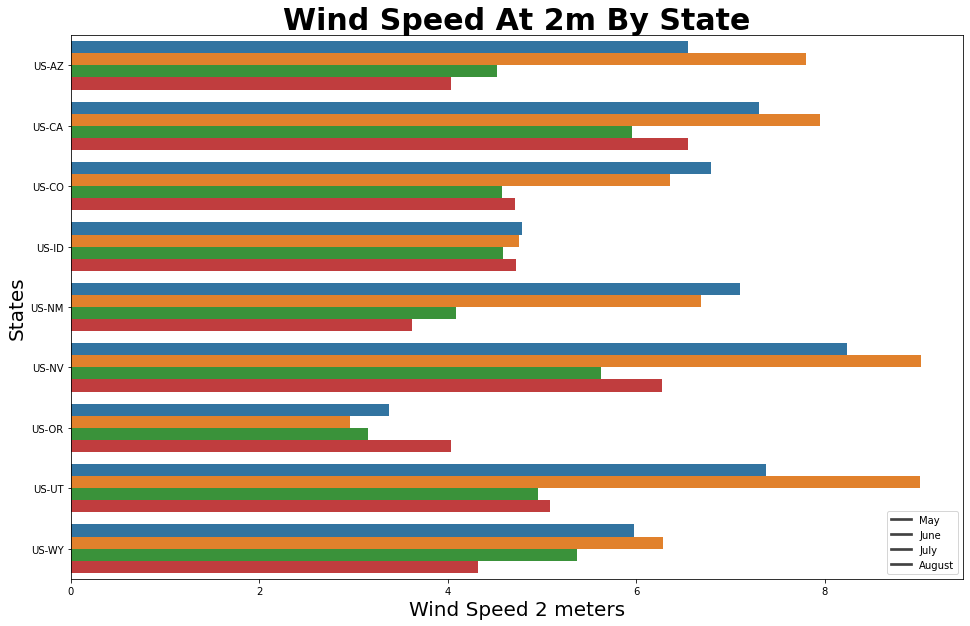

In [619]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="wind_speed_2m",
    file_path="../../public/visuals/fire_wind_speed_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Wind Speed At 2m By State',
    xlabel='Wind Speed 2 meters',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


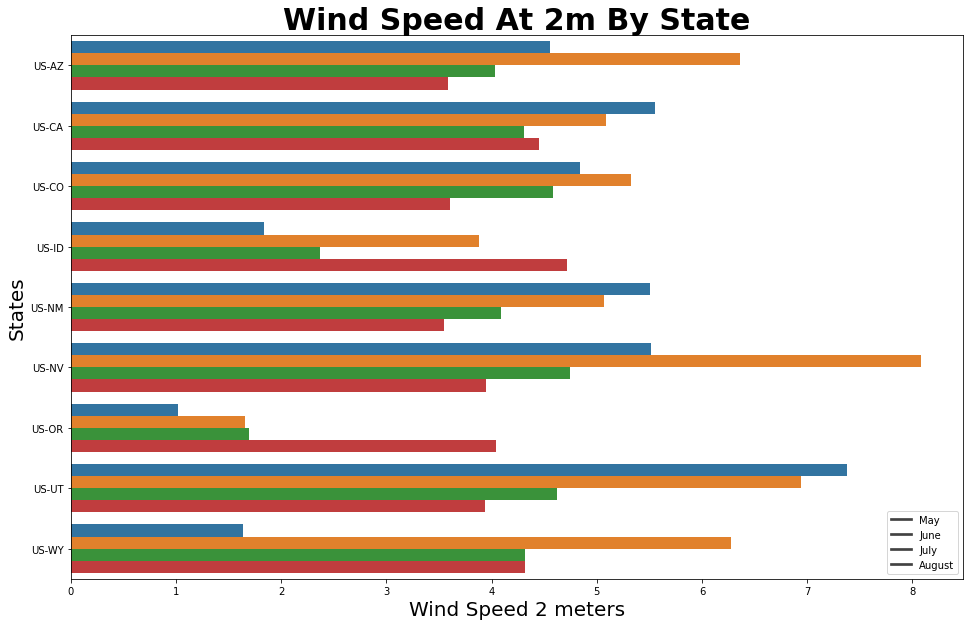

In [620]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="wind_speed_2m",
    file_path="../../public/visuals/fire_wind_speed_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Wind Speed At 2m By State',
    xlabel='Wind Speed 2 meters',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Rain By State

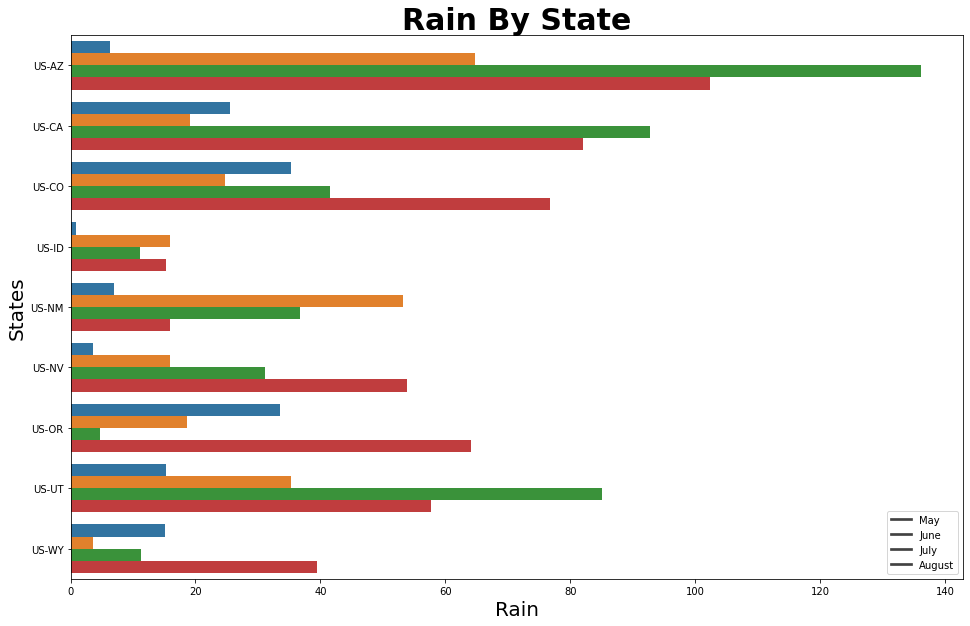

In [621]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain",
    file_path="../../public/visuals/fire_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Rain By State',
    xlabel='Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


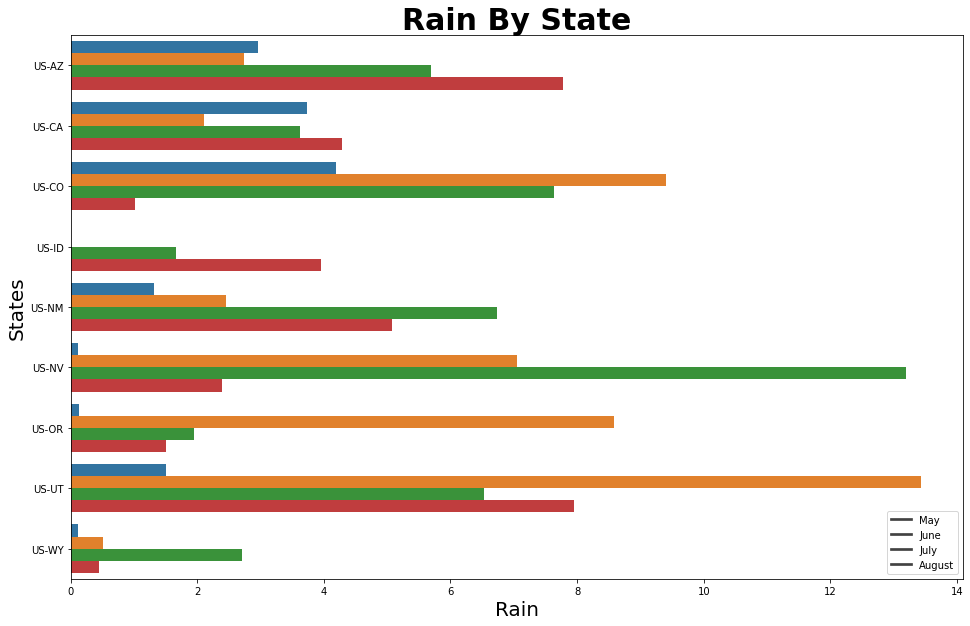

In [622]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain",
    file_path="../../public/visuals/big_fire_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Rain By State',
    xlabel='Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Snow By State

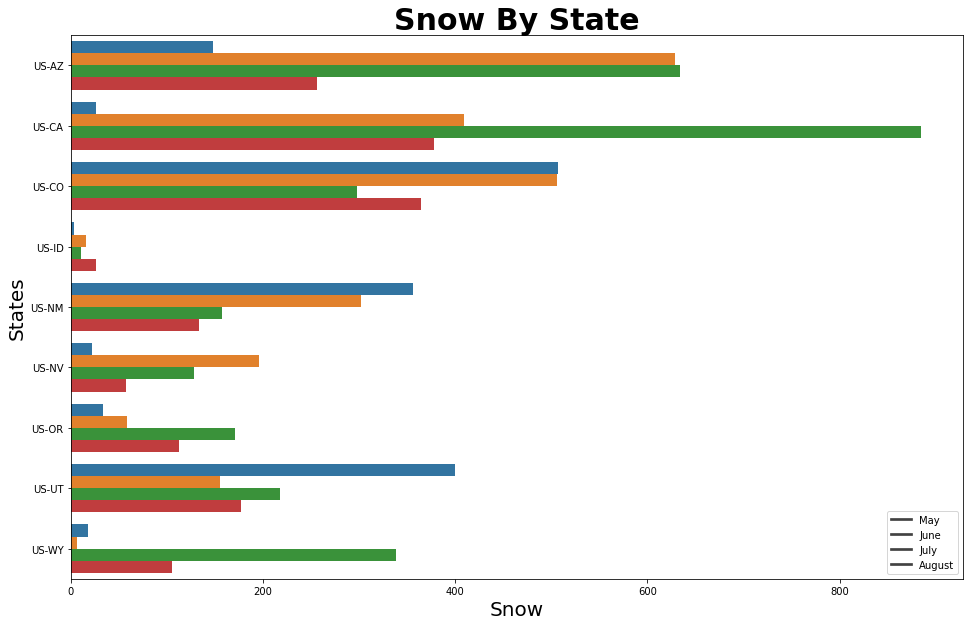

In [623]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum",
    file_path="../../public/visuals/fire_snow_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Snow By State',
    xlabel='Snow',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


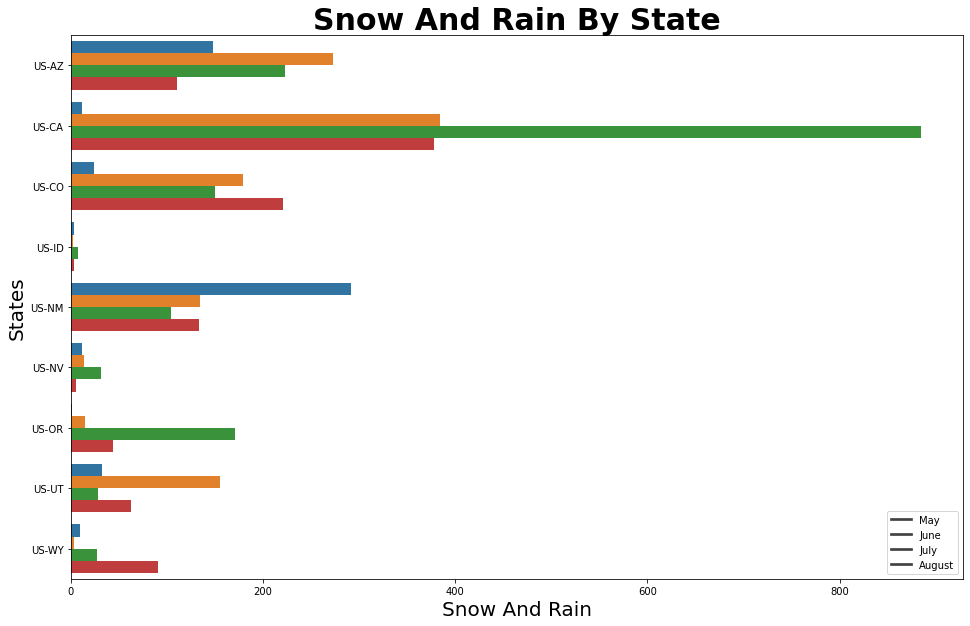

In [624]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="rain_sum",
    file_path="../../public/visuals/big_fire_snow_rain_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Snow And Rain By State',
    xlabel='Snow And Rain',
    ylabel='States',
    hue='firediscoverydatetime_month'
)


----
# Time Took To Control By State

In [625]:
all_fire_weather['time_took'] = all_fire_weather['controldatetime'] - all_fire_weather['firediscoverydatetime']
all_fire_weather['time_took'] = round(all_fire_weather['time_took'].dt.total_seconds()/60/60)

big_fire_weather['time_took'] = big_fire_weather['controldatetime'] - big_fire_weather['firediscoverydatetime']
big_fire_weather['time_took'] = round(big_fire_weather['time_took'].dt.total_seconds()/60/60)

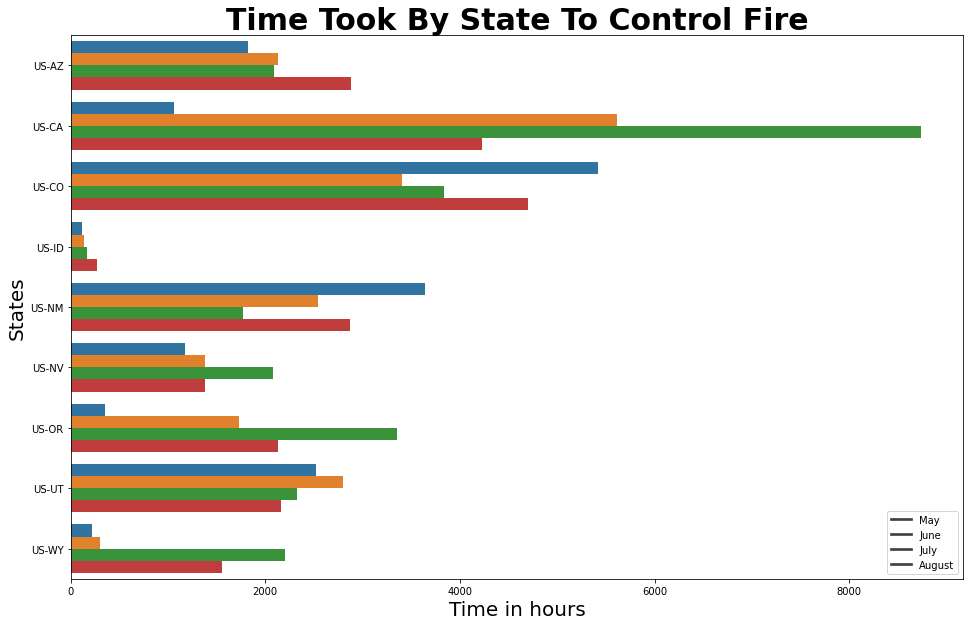

In [626]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="time_took",
    file_path="../../public/visuals/fire_time_control_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Time Took By State To Control Fire',
    xlabel='Time in hours',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


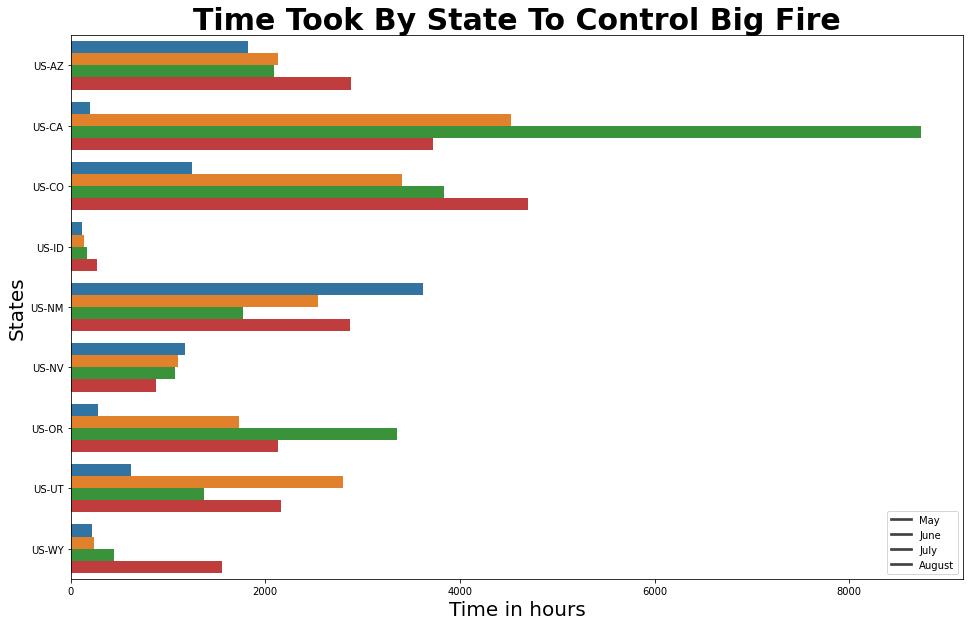

In [627]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="time_took",
    file_path="../../public/visuals/big_fire_time_control_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Time Took By State To Control Big Fire',
    xlabel='Time in hours',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


----

# Acres Burned By State

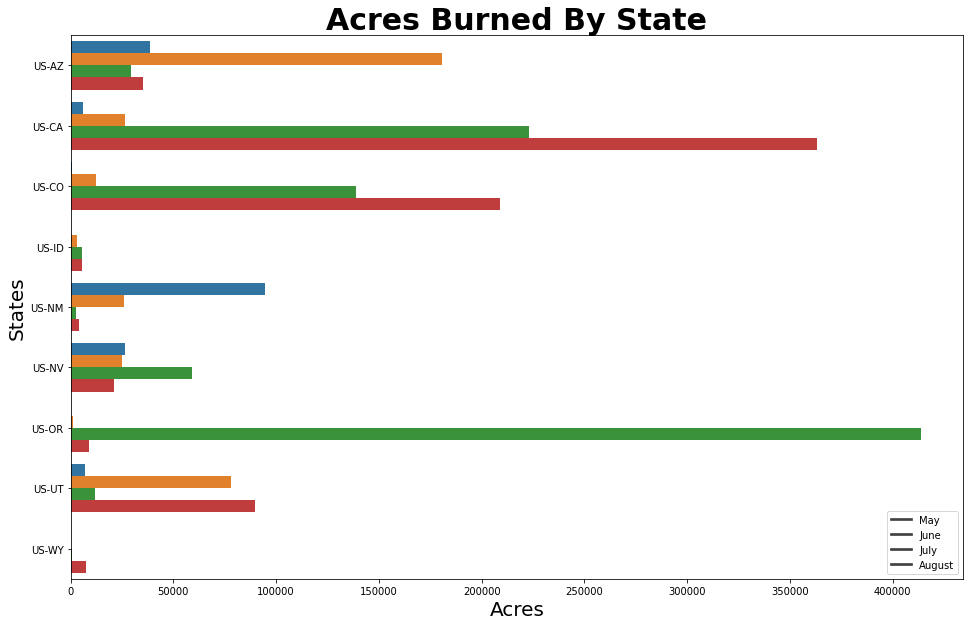

In [628]:
plot_per_state(
    all_fire_weather[
        (all_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (all_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="dailyacres",
    file_path="../../public/visuals/fire_acres_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Acres Burned By State',
    xlabel='Acres',
    ylabel='States',
    hue='firediscoverydatetime_month',
)


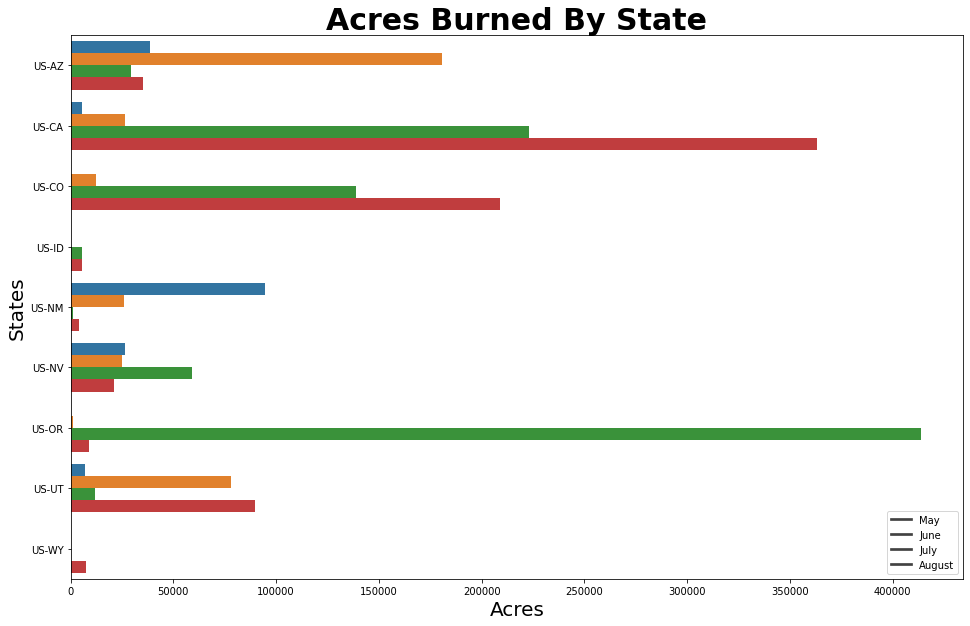

In [629]:
plot_per_state(
    big_fire_weather[
        (big_fire_weather["firediscoverydatetime_month"] <= peak_fire_month['max'])
        & (big_fire_weather["firediscoverydatetime_month"] >= peak_fire_month['min'])
    ],
    target="dailyacres",
    file_path="../../public/visuals/big_fire_acres_by_state",
    hue_labels=list(calendar.month_name)[peak_fire_month['min']:peak_fire_month['max']+1],
    title='Acres Burned By State',
    xlabel='Acres',
    ylabel='States',
    hue='firediscoverydatetime_month',
)
